# Load TCIA with `CSVDataset` and process it

This tutorial shows how to load the TCIA data with `CSVDataset` from CSV file and extract information for TCIA data to fetch DICOM images based on REST API.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/tcia_csv_processing.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pandas, pillow]"
%matplotlib inline

## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import tempfile
import shutil
import matplotlib.pyplot as plt
import pandas as pd
from typing import Any, Callable, Dict, Optional, Sequence, Union

from monai.data import CSVDataset
from monai.apps import download_url, download_and_extract
from monai.transforms import LoadImaged
from monai.config import print_config
from monai.utils import ensure_tuple

print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


## Define TCIADataset
It contains below main logic:
1. Automatically download the TCIA CSV file.
2. Load the CSV file content based on `CSVDataset`.
3. Download the raw DICOM image to specified path if not existing.
4. Execute transforms at runtime.

In [3]:
class TCIADataset(CSVDataset):
    """
    Dataset to automatically download TCIA data and load.
    Args:
        url: the url to download csv file, if providing a list of urls, every url
            match to a filename.
        filename: the filename to save and load downloaded csv file. if providing a list
            of filenames, it will load all the files and join tables.
        img_dir: root directory to save downloaded raw DICOM images.
        row_indices: indices of the expected rows to load. it should be a list,
            every item can be a int number or a range `[start, end)` for the indices.
            for example: `row_indices=[[0, 100], 200, 201, 202, 300]`. if None,
            load all the rows in the file.
        col_names: names of the expected columns to load. if None, load all the columns.
        col_types: `type` and `default value` to convert the loaded columns, if None, use original data.
            it should be a dictionary, every item maps to an expected column, the `key` is the column
            name and the `value` is None or a dictionary to define the default value and data type.
            the supported keys in dictionary are: ["type", "default"]. for example::
                col_types = {
                    "subject_id": {"type": str},
                    "label": {"type": int, "default": 0},
                    "ehr_0": {"type": float, "default": 0.0},
                    "ehr_1": {"type": float, "default": 0.0},
                    "image": {"type": str, "default": None},
                }
        col_groups: args to group the loaded columns to generate a new column,
            it should be a dictionary, every item maps to a group, the `key` will
            be the new column name, the `value` is the names of columns to combine. for example:
            `col_groups={"ehr": [f"ehr_{i}" for i in range(10)], "meta": ["meta_1", "meta_2"]}`
        transform: transform to apply on the loaded items of a dictionary data.
        kwargs: additional arguments for `pandas.merge()` API to join tables.

    """
    def __init__(
        self,
        url: Union[str, Sequence[str]],
        filename: Union[str, Sequence[str]],
        img_dir: str,
        row_indices: Optional[Sequence[Union[int, str]]] = None,
        col_names: Optional[Sequence[str]] = None,
        col_types: Optional[Dict[str, Optional[Dict[str, Any]]]] = None,
        col_groups: Optional[Dict[str, Sequence[str]]] = None,
        transform: Optional[Callable] = None,
        **kwargs,
    ):
        url = ensure_tuple(url)
        filename = ensure_tuple(filename)
        if len(url) != len(filename):
            raise ValueError("number of URLs must match the number of filenames.")

        for u, f in zip(url, filename):
            if not os.path.exists(f):
                download_url(url=u, filepath=f)

        super().__init__(
            src=filename,
            row_indices=row_indices,
            col_names=col_names,
            col_types=col_types,
            col_groups=col_groups,
            transform=transform,
            kwargs=kwargs,
        )
        self.img_dir = img_dir

    def _get_image(self, series_uid: str):
        # download raw DICOM series based on `Series UID`
        data_dir = os.path.join(self.img_dir, f"{series_uid}")
        url = "https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?SeriesInstanceUID=" + series_uid
        if not os.path.exists(data_dir):
            download_and_extract(url=url, filepath=data_dir + ".zip", output_dir=data_dir)
        return data_dir

    def __getitem__(self, index: Union[int, slice, Sequence[int]]):
        if isinstance(index, int):
            series_uid = self.data[index]["Series UID"]
            self.data[index]["image"] = self._get_image(series_uid)
        return super().__getitem__(index=index)

## Download and Load the CSV file with `TCIADataset`
Here we use the demo data in Google drive:
https://drive.google.com/file/d/1HQ7BZvBr1edmi8HIwdG5KBweXWms5Uzk/view?usp=sharing 

Expect the first row of CSV file to be titles of columns. we only use the first 8 rows to execute demo processing.

In [4]:
dataset = TCIADataset(
    url="https://drive.google.com/uc?id=1HQ7BZvBr1edmi8HIwdG5KBweXWms5Uzk",
    filename=os.path.join(root_dir, "ISPY1_Combined.csv"),
    img_dir=os.path.join(root_dir, "tcia_images"),
    row_indices=[[0, 8]],
    transform=LoadImaged(keys="image"),
)

Downloading...
From: https://drive.google.com/uc?id=1HQ7BZvBr1edmi8HIwdG5KBweXWms5Uzk
To: /tmp/tmpxxvxwwim/ISPY1_Combined.csv
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327k/327k [00:00<00:00, 2.26MB/s]

Downloaded: /workspace/data/medical/ISPY1_Combined.csv
Expected md5 is None, skip md5 check for file /workspace/data/medical/ISPY1_Combined.csv.


In [5]:
# construct pandas table to show the raw data, `CSVDataset` inherits from PyTorch Dataset
print(pd.DataFrame(dataset.data))

  Collection  Patient Id Study Date               Study Description Modality  \
0      ISPY1  ISPY1_1005   6/7/1985             MRI BREAST UNI/MBRU       MR   
1      ISPY1  ISPY1_1008  2/15/1985                  MR BREAS, UNIT       MR   
2      ISPY1  ISPY1_1016  7/20/1985             MRI BREAST BIL/MBRB       MR   
3      ISPY1  ISPY1_1018   6/1/1985  MRI BREAST BILAT W+ OR WO CONT       MR   
4      ISPY1  ISPY1_1019  11/7/1985             MRI BREAST BIL/MBRB       MR   
5      ISPY1  ISPY1_1022  6/29/1985   MRI BREAST/UNILAT WO/WITH CON       MR   
6      ISPY1  ISPY1_1024  6/17/1985  MRI BREAST BILAT W+ OR WO CONT       MR   
7      ISPY1  ISPY1_1034  12/5/1985             MRI BREAST UNI/MBRU       MR   

             Series Description        Manufacturer    Manufacturer Model  \
0                        SAG T2  GE MEDICAL SYSTEMS         GENESIS_SIGNA   
1  T2-FSE-Sagittal RIGHT BREAST  GE MEDICAL SYSTEMS         GENESIS_SIGNA   
2                        SAG T2  GE MEDICAL SYST

## Download raw DICOM series at runtime and execute transform
In this demo, we extract the series UID from loaded TCIA table and try to download the DICOM raw images with REST API, more details: https://wiki.cancerimagingarchive.net/display/Public/TCIA+REST+API+Guide

In [7]:
data = dataset[0]
print(f"Series UID is: {data['Series UID']}")

1.3.6.1.4.1.14519.5.2.1.7695.1700.506244151085816331158034893215.zip: 1.74MB [00:22, 82.5kB/s]


Downloaded: /workspace/data/medical/tcia_images/1.3.6.1.4.1.14519.5.2.1.7695.1700.506244151085816331158034893215.zip
Expected md5 is None, skip md5 check for file /workspace/data/medical/tcia_images/1.3.6.1.4.1.14519.5.2.1.7695.1700.506244151085816331158034893215.zip.
Writing into directory: /workspace/data/medical/tcia_images/1.3.6.1.4.1.14519.5.2.1.7695.1700.506244151085816331158034893215.
Series UID is: 1.3.6.1.4.1.14519.5.2.1.7695.1700.506244151085816331158034893215


## Plot the loaded DICOM series content
Here we access the loaded DICOM image by key `image`, then plot several slices.

image shape: (256, 256, 24), min value: 0.0, max value: 1624.0


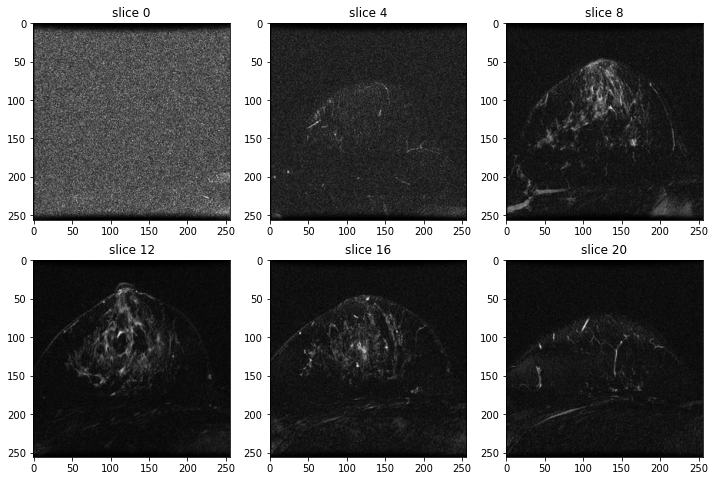

In [8]:
img = data["image"]
print(f"image shape: {img.shape}, min value: {img.min()}, max value: {img.max()}")

plt.figure("check", (12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.title(f"slice {i * 4}")
    plt.imshow(img[:, :, i * 4], cmap="gray")
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [14]:
if directory is None:
    shutil.rmtree(root_dir)